In [2]:
import re
import sklearn
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 14
from matplotlib import cm
from functools import reduce
import matplotlib.pyplot as plt

## Auxillary functions to process the data

In [3]:
def discard_nan_columns(df, threshold=0.1, inplace=True):
    """
    Discard the columns in a dataframe which contains too many nan values

    Args:
        df (pd.DataFrame): the dataframe to be proceeded.
        threshold (float): if the fraction of the missing data is greather
            than the threshold, discard this column.
        inplace (bool): if True, modify the dataframe in place, otherwise
            return a new dataframe.
    """
    to_retain = []
    missing = df.isnull()
    for column in missing.columns:
        missing_fraction = missing[column].sum() / len(missing[column])
        if missing_fraction < threshold:
            to_retain.append(column)
    return df[to_retain]


def gauge_feature(correlations, threshold=1e-2, binary=True):
    """
    Convert categorical data into numericals according to
        its correlation with the result

    Not correlated = 0
    Positively correlated = 1, 2, ...
    Negatively correlated = -1, -2, ...
    
    Args:
        correlations (np.ndarray): the correlation coefficients
        threshold (float): if the correlation coefficients is smaller
            than this value, the corresponding feature is consdered as
            not correlated with the result

    Example:
        >>> gauge_feature([-0.2, -0.5, -0.0002, 0.00005, 5, 10, 15, -5])
        array([-1, -2, 0, 0, 1, 2, 3, -3])
        >>> gauge_feature([-0.2, -0.5, -0.0002, 0.00005, 5, 10, 15, -5], binary=True)
        array([-1, -1, 0, 0, 1, 1, 1, -1])
    """
    correlations = np.array(correlations)
    gauges = np.zeros(len(correlations))
    corr_abs = np.abs(correlations)
    corr_sig = np.array(correlations[corr_abs > threshold])
    labels_p = np.arange((corr_sig > 0).sum()) + 1  # 0.1, 1.2, 4.4 -> 1, 2, 3
    labels_n = np.arange(-(corr_sig < 0).sum(), 0)  # -0.2, -2.3 -> -2, -1
    labels = np.concatenate((
        labels_n,
        np.zeros((corr_abs <= threshold).sum()),
        labels_p
    ))  # -> [-2, -1, 0, 0, ..., 0, 1, 2, 3]
    orders = np.argsort(correlations)
    for i, j in enumerate(orders):
        # i -> index of ordered array; j -> index of origional array
        gauges[j] = labels[i]
    if binary:
        gauges[gauges > 0] = 1
        gauges[gauges < 0] = -1
    return gauges.astype(int)


def process_weather(df_feature, df_raw, remap):
    """
    Evaluating the following names into numerical values
        based on the gauged feature

    'Snowing + high winds', 'Snowing no high winds',
    'Fine + high winds', 'Fine no high winds',
    'Raining + high winds', 'Raining no high winds'

    The evaluated result is updated to df_feature inplace.

    Args:
        df_feature (pd.DataFrame): the feature to store numerical values
        df_raw (pd.DataFrame): the dataframe that contains the raw data
        remap (dict): the dict to map feature names to numerical values
    """
    names_compound = df_raw['Weather_Conditions'].unique()
    remap_compound = {}
    for name in names_compound:
        if '+' in name:
            # canonical name = Snowing, Fine, High wind ...
            canonical_names = re.split('\s+\+\s+', name)
            compound_values = [remap[cn[0].upper() + cn[1:]] for cn in canonical_names]
            remap_compound.update({name : sum(compound_values)})
        elif ' no ' in name:
            canonical_name = re.split('\s+', name)[0].title()
            remap_compound.update({name : remap[canonical_name]})
        else:
            remap_compound.update({name : remap[name]})
    df_feature['Weather_Conditions'].replace(remap_compound, inplace=True)


def process_brightness(df_feature, df_raw, remap):
    """
    Updating the light conditions only according to daylight or darkness.

    The evaluated result is updated to df_feature inplace.

    Args:
        df_feature (pd.DataFrame): the feature to store numerical values
        df_raw (pd.DataFrame): the dataframe that contains the raw data
        remap (dict): the dict to map feature names to numerical values
    """
    names_compound = df_raw['Light_Conditions'].unique()
    remap_compound = {}
    for name in names_compound:
        if 'darkness' in name.lower():
            remap_compound.update({name : remap['Darkness']})
        else:
            remap_compound.update({name : remap['Daylight']})
    df_feature['Light_Conditions'].replace(remap_compound, inplace=True)

## Processing the Accident Information

1. Load the `.csv` file
2. Discard all missing data. If one column contains too many missing entries, drop the volumn.
3. Finely process some volumns
4. Use one-hot coding to encode the catogerical features
5. Store all the result into one dataframe, `df_acc`


In [4]:
df_acc = pd.read_csv('../uk-car-accident/Accident_Information.csv')

# discard missing values
df_acc.replace('Data missing or out of range', np.nan, inplace=True)
df_acc.replace('Unclassified', np.nan, inplace=True)
df_acc.replace('Unknown', np.nan, inplace=True)
df_acc.replace('Other', np.nan, inplace=True)
df_acc.replace('None', np.nan, inplace=True)
df_acc = discard_nan_columns(df_acc, 0.1)
df_acc.dropna(axis=0, inplace=True)
df_acc.reset_index(drop=True, inplace=True)

# coarse-grain the time
df_acc['Time'] = pd.to_datetime(df_acc['Time'], format="%H:%M").dt.hour
# fix the dates
df_acc['Date'] = pd.to_datetime(df_acc['Date'])

In [5]:
percent_slight = np.sum(df_acc['Accident_Severity'] == 'Slight') / len(df_acc['Accident_Severity'])
percent_serious = np.sum(df_acc['Accident_Severity'] == 'Serious') / len(df_acc['Accident_Severity'])
percent_fatal = np.sum(df_acc['Accident_Severity'] == 'Fatal') / len(df_acc['Accident_Severity'])

print(f"Out of {len(df_acc['Accident_Severity'])} cases, {percent_slight * 100:.2f}% were slight, {percent_serious * 100:.2f}% were serious, and sadly {percent_fatal * 100:.2f}% were fatal.")

Out of 1793224 cases, 84.79% were slight, 13.95% were serious, and sadly 1.26% were fatal.


In [6]:
# binarise the accident severity
df_acc['Accident_Severity'].replace('Slight', 0, inplace=True)
df_acc['Accident_Severity'].replace('Serious', 1, inplace=True)
df_acc['Accident_Severity'].replace('Fatal', 2, inplace=True)

In [7]:
# manually choose features
label_acc = 'Accident_Severity'
features_acc = {
    "id" : 'Accident_Index',
    "numerical" : ['Speed_limit', 'Time'],
    "categorical": [
        'Day_of_Week', 'Junction_Detail', 'Light_Conditions',
        'Road_Surface_Conditions', 'Road_Type', 'Urban_or_Rural_Area',
        'Weather_Conditions'
    ]
}

features_num_acc = df_acc[features_acc["numerical"]]
features_cat_acc = pd.concat(
    [pd.get_dummies(df_acc[c], prefix=c.replace("_", " "), prefix_sep=": ") for c in features_acc['categorical']],
    axis=1
)


Since there are some columns that are inter-related with logic. It is reasonable to split the columns into orthogonal features.

For instance,

```python
'Snowing + high winds', 'Snowing no high winds',
'Fine + high winds', 'Fine no high winds',
'Raining + high winds', 'Raining no high winds'
```

might be splited into


```python
'Snowing', 'Fine', 'Raining'
```

In [8]:
features_cat_acc['Weather Conditions: Raining'] = reduce(
    lambda x, y: np.logical_or(x, y),
    [features_cat_acc[c] for c in features_cat_acc.columns if 'rain' in c.lower()]
).astype(int)

features_cat_acc['Weather Conditions: Snowing'] = reduce(
    lambda x, y: np.logical_or(x, y),
    [features_cat_acc[c] for c in features_cat_acc.columns if 'snow' in c.lower()]
).astype(int)

features_cat_acc['Weather Conditions: High winds'] = reduce(
    lambda x, y: np.logical_or(x, y),
    [features_cat_acc[c] for c in features_cat_acc.columns if '+ high winds' in c.lower()]
).astype(int)

features_cat_acc['Weather Conditions: Fine'] = reduce(
    lambda x, y: np.logical_or(x, y),
    [features_cat_acc[c] for c in features_cat_acc.columns if 'fine' in c.lower()]
).astype(int)

features_cat_acc['Light Conditions: Darkness'] = reduce(
    lambda x, y: np.logical_or(x, y),
    [features_cat_acc[c] for c in features_cat_acc.columns if 'darkness' in c.lower()]
).astype(int)

to_drop  = [c for c in features_cat_acc.columns if 'Darkness ' in c]
to_drop += [c for c in features_cat_acc.columns if 'Raining ' in c]
to_drop += [c for c in features_cat_acc.columns if 'Snowing ' in c]
to_drop += [c for c in features_cat_acc.columns if 'Fine ' in c]

features_cat_acc.drop(labels=to_drop, axis=1, inplace=True)

Now combine all the features as well as the label and the ID into one dataframe

In [9]:
df_acc_refined = pd.concat([
    df_acc[label_acc],
    df_acc[features_acc["id"]],
    features_num_acc,
    features_cat_acc
], axis=1)
df_acc_refined.head()

,Accident_Severity,Accident_Index,Speed_limit,Time,Day of Week: Friday,Day of Week: Monday,Day of Week: Saturday,Day of Week: Sunday,Day of Week: Thursday,Day of Week: Tuesday,...,Road Type: Single carriageway,Road Type: Slip road,Urban or Rural Area: Rural,Urban or Rural Area: Urban,Weather Conditions: Fog or mist,Weather Conditions: Raining,Weather Conditions: Snowing,Weather Conditions: High winds,Weather Conditions: Fine,Light Conditions: Darkness
0,1,200501BS00001,30.0,17,0,0,0,0,0,1,...,1,0,0,1,0,1,0,0,0,0
1,0,200501BS00002,30.0,17,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,1
2,0,200501BS00003,30.0,0,0,0,0,0,1,0,...,1,0,0,1,0,0,0,0,1,1
3,0,200501BS00004,30.0,10,1,0,0,0,0,0,...,1,0,0,1,0,0,0,0,1,0
4,0,200501BS00005,30.0,21,0,1,0,0,0,0,...,1,0,0,1,0,0,0,0,1,1


## Process the Vehicle Information

1. Load the `.csv` file
2. Discard all missing data. If one column contains too many missing entries, drop the volumn.
3. Finely process some volumns
4. Use one-hot coding to encode the catogerical features
5. Store all the result into one dataframe, `df_vec`

In [10]:
df_vec = pd.read_csv('../uk-car-accident/Vehicle_Information.csv', encoding='windows-1252')
# discard missing values
df_vec.replace('Data missing or out of range', np.nan, inplace=True)
df_vec.replace('Unclassified', np.nan, inplace=True)
df_vec.replace('Unknown', np.nan, inplace=True)
df_vec.replace('Not known', np.nan, inplace=True)
df_vec.replace('Other', np.nan, inplace=True)
df_vec.replace('None', np.nan, inplace=True)
df_vec = discard_nan_columns(df_vec, 0.2)
df_vec.dropna(axis=0, inplace=True)
df_vec.reset_index(drop=True, inplace=True)

# select features_vec manually
features_vec = {
    "id" : 'Accident_Index',
    "numerical" : [
        'Age_of_Vehicle',  'Age_Band_of_Driver', 'Engine_Capacity_.CC.'
        ],
    "categorical": [
        'Propulsion_Code', 'Sex_of_Driver', 'Vehicle_Leaving_Carriageway',
        'Vehicle_Manoeuvre', 'Vehicle_Type',
    ]
}

features_num_vec = df_vec[features_vec["numerical"]]
# process age band, split into two columns
features_num_vec['Age_Band_Min'] = features_num_vec['Age_Band_of_Driver'].str.split(' - ', expand=True)[0]
features_num_vec['Age_Band_Max'] = features_num_vec['Age_Band_of_Driver'].str.split(' - ', expand=True)[1]
features_num_vec['Age_Band_Min'].replace('Over 75', np.nan, inplace=True)
features_num_vec.drop('Age_Band_of_Driver', axis=1, inplace=True)

features_cat_vec = pd.concat(
    [pd.get_dummies(df_vec[c], prefix=c.replace("_", " "), prefix_sep=": ") for c in features_vec['categorical']],
    axis=1
)

df_vec_refined = pd.concat([
    df_vec[features_vec["id"]], features_num_vec, features_cat_vec
], axis=1)
df_vec_refined.dropna(axis=0, inplace=True)
df_vec_refined['Age_Band_Min'] = df_vec_refined['Age_Band_Min'].astype(int)
df_vec_refined['Age_Band_Max'] = df_vec_refined['Age_Band_Max'].astype(int)

df_vec_refined.head()

,Accident_Index,Age_of_Vehicle,Engine_Capacity_.CC.,Age_Band_Min,Age_Band_Max,Propulsion Code: Electric diesel,Propulsion Code: Gas,Propulsion Code: Gas Diesel,Propulsion Code: Gas/Bi-fuel,Propulsion Code: Heavy oil,...,Vehicle Type: Goods vehicle - unknown weight,Vehicle Type: Minibus (8 - 16 passenger seats),Vehicle Type: Motorcycle - unknown cc,Vehicle Type: Motorcycle 125cc and under,Vehicle Type: Motorcycle 50cc and under,Vehicle Type: Motorcycle over 125cc and up to 500cc,Vehicle Type: Motorcycle over 500cc,Vehicle Type: Other vehicle,Vehicle Type: Taxi/Private hire car,Vehicle Type: Van / Goods 3.5 tonnes mgw or under
0,200501BS00004,4.0,1769.0,46,55,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,200501BS00006,1.0,2976.0,46,55,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,200501BS00006,2.0,124.0,26,35,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,200501BS00007,4.0,4266.0,36,45,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,200501BS00009,16.0,5343.0,66,75,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Merge the two table

The code below merges the accident dataframe and the vehicle dataframe, according to the `Accident_Index` column

In [11]:
df = pd.merge(df_acc_refined, df_vec_refined, on=['Accident_Index'])
df.drop('Accident_Index', inplace=True, axis=1)

## Explore the database

Now I have all the raw data that I need. I will first take a look the correlation between the severity with all the features

In [12]:
corr_2d = df.corr()
corr = corr_2d['Accident_Severity'][1:]


### Visualise the correlations

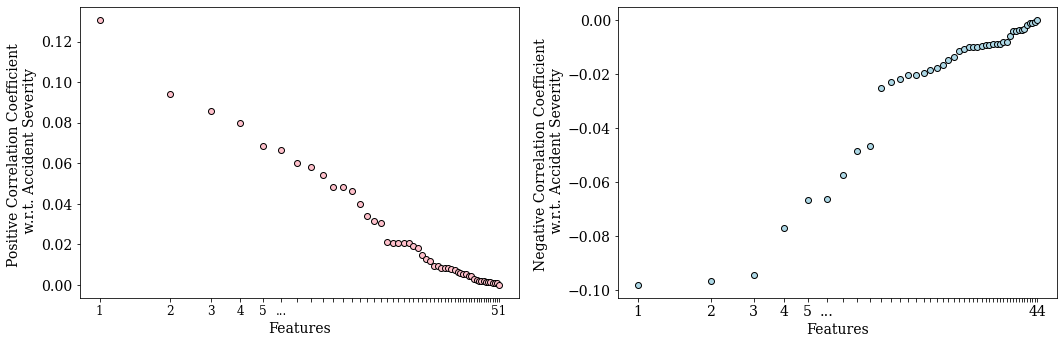

In [13]:
feature_num = 5

p_corr = corr[corr > 0]
n_corr = corr[corr < 0]
p_order = np.argsort(p_corr)
n_order = np.argsort(n_corr)
p_x = np.log(np.arange(len(p_corr)) + 1)
n_x = np.log(np.arange(len(n_corr)) + 1)

# plot
fig = plt.figure(figsize=(15, 5))
p_xlabels = [f'{i + 1}' for i in range(feature_num)] + ['...'] 
p_xlabels += [''] * (len(p_x) - feature_num - 2) + [len(p_x)]
n_xlabels = [f'{i + 1}' for i in range(feature_num)] + ['...']
n_xlabels += [''] * (len(n_x) - feature_num - 2) + [len(n_x)]
# left
ax0, ax1 = fig.subplots(1, 2)
ax0.scatter(p_x, p_corr[p_order][::-1], color='pink', edgecolor='k')
ax0.set_xticks(p_x)
ax0.set_xticklabels(p_xlabels, fontsize=12)
ax0.set_xlabel('Features')
ax0.set_ylabel('Positive Correlation Coefficient \n w.r.t. Accident Severity')
# right
ax1.scatter(n_x, n_corr[n_order], color='lightblue', edgecolor='k')
ax1.set_xticks(n_x)
ax1.set_xticklabels(n_xlabels)
ax1.set_ylabel('Negative Correlation Coefficient \n w.r.t. Accident Severity')
ax1.set_xlabel('Features')
plt.tight_layout()
plt.savefig('correlations.pdf')
plt.show()

The above plot looks promising! I would naively expect most features to be uncorrelated at all. After, changing the severity category into numerical value is a quite rogue behaviour. There is not justificaion for the values that I chosen. Namely,

- "Slight" = 1
- "Serious" = 2
- "Fatal" = 3

As a physists, I have to pointed out these values are non-sense because they lack a proper unit. Specifically, the *distance* between "Slight" and "Serious" is 1, which equals the *distance* between "Serious" and "Fatal". It is not clear to me why these distances should be the same.

But let's be babarian and proceed to check if the highly correlated/anti-correlated features makes sense.

### Report the Import Correlations

In [267]:
print('-' * 50)
print("The 10 features leading to severe road accidents:\n")
order = np.argsort(corr)
for feature in df.columns[1:][order][-10:][::-1]:
    print(
        re.sub('_', ' ', feature),
        f'correlation: {corr[list(df.columns[1:]).index(feature)] * 100:.2f} %'
    )
print()
print('-' * 50)
print("The 10 features rejecting severe road accidents:\n")
order = np.argsort(corr)
for feature in df.columns[1:][order][:10]:
    print(
        re.sub('_', ' ', feature),
        f'correlation: {corr[list(df.columns[1:]).index(feature)] * 100:.2f} %'
    )


--------------------------------------------------
The 10 features leading to severe road accidents:

Vehicle Type: Motorcycle over 500cc correlation: 13.06 %
Urban or Rural Area: Rural correlation: 9.44 %
Speed limit correlation: 8.61 %
Junction Detail: Not at junction or within 20 metres correlation: 7.98 %
Vehicle Leaving Carriageway: Nearside correlation: 6.83 %
Sex of Driver: Male correlation: 6.65 %
Vehicle Leaving Carriageway: Offside correlation: 6.01 %
Vehicle Manoeuvre: Going ahead left-hand bend correlation: 5.83 %
Vehicle Manoeuvre: Going ahead right-hand bend correlation: 5.41 %
Light Conditions: Darkness correlation: 4.86 %

--------------------------------------------------
The 10 features rejecting severe road accidents:

Vehicle Leaving Carriageway: Did not leave carriageway correlation: -9.79 %
Vehicle Type: Car correlation: -9.68 %
Urban or Rural Area: Urban correlation: -9.44 %
Vehicle Manoeuvre: Waiting to go - held up correlation: -7.69 %
Sex of Driver: Female cor

The result makes sense because it matches my daily experience. The take-home message is that <big> do not travel in a **rural** area with a **big motorcycle** in a road with **high speed limit** in the **dark** as a **male**.</big>

### Visualising the Structure of the data

I will project the data onto the first 2 main components and I will discover if there are any structure.

In [15]:
for category in features_acc['categorical']:
    category = category.replace('_', ' ')
    indices = np.array([
        i for i, c in enumerate(df.columns) if f'{category}:' in c
    ])
    names = [df.columns[i][len(category)+2:] for i in indices]

    for n, c in zip(names, corr[indices - 1]):
        print(f"{category: <40} {n: <50}: {c * 100:.2f} %")

for category in features_vec['categorical']:
    category = category.replace('_', ' ')
    indices = np.array([
        i for i, c in enumerate(df.columns) if f'{category}:' in c
    ])
    names = [df.columns[i][len(category)+2:] for i in indices]

    for n, c in zip(names, corr[indices - 1]):
        print(f"{category: <40} {n: <50}: {c * 100:.2f} %")

Day of Week                              Friday                                            : -0.80 %
Day of Week                              Monday                                            : -0.93 %
Day of Week                              Saturday                                          : 1.82 %
Day of Week                              Sunday                                            : 3.17 %
Day of Week                              Thursday                                          : -0.89 %
Day of Week                              Tuesday                                           : -0.91 %
Day of Week                              Wednesday                                         : -0.96 %
Junction Detail                          Crossroads                                        : -2.51 %
Junction Detail                          Mini-roundabout                                   : -1.68 %
Junction Detail                          More than 4 arms (not roundabout)                 : 

In [310]:
df_features = df[[
    'Accident_Severity', 'Speed_limit', 'Time',
    'Age_of_Vehicle', 'Engine_Capacity_.CC.',
    'Age_Band_Min', 'Age_Band_Max'
]]
binary = True
corr_threshold = 1e-2
feature_gauge_map = {}

for feature_dict, df_raw in zip([features_acc, features_vec], [df_acc, df_vec]):
    for category in feature_dict['categorical']:
        category_name = category.replace('_', ' ')
        indices = np.array([
            i for i, c in enumerate(df.columns) if f'{category_name}:' in c
        ])
        full_names = [df.columns[i] for i in indices]
        feature_names = [df.columns[i][len(category_name)+2:] for i in indices]
        correlations = corr[indices - 1]  # -1 because corr ignores the 1st element
        gauge = gauge_feature(correlations, corr_threshold, binary)
        if np.abs(gauge).sum() > 0:
            df_features[category] = df_raw[category]
            remap = dict(zip(feature_names, gauge))
            feature_gauge_map.update(dict(zip(full_names, gauge)))
            if category == 'Weather_Conditions':
                process_weather(df_features, df_raw, remap)
            elif category == 'Light_Conditions':
                process_brightness(df_features, df_raw, remap)
            else:
                df_features[category].replace(remap, inplace=True)


In [311]:
df_features.head()

,Accident_Severity,Speed_limit,Time,Age_of_Vehicle,Engine_Capacity_.CC.,Age_Band_Min,Age_Band_Max,Day_of_Week,Junction_Detail,Light_Conditions,Road_Type,Urban_or_Rural_Area,Weather_Conditions,Propulsion_Code,Sex_of_Driver,Vehicle_Leaving_Carriageway,Vehicle_Manoeuvre,Vehicle_Type
0,0,30.0,10,4.0,1769.0,46,55,0,1,-1,1,-1,-1,1,-1,-1,1,-1
1,0,30.0,12,1.0,2976.0,46,55,0,-1,1,-1,-1,1,1,1,-1,-1,-1
2,0,30.0,12,2.0,124.0,26,35,0,1,1,1,-1,1,1,-1,-1,1,1
3,0,30.0,20,4.0,4266.0,36,45,0,1,-1,1,-1,1,1,1,-1,0,-1
4,0,30.0,17,16.0,5343.0,66,75,0,1,1,1,-1,1,1,1,1,1,-1


In [312]:
feature_gauge_map

{'Day of Week: Friday': 0,
 'Day of Week: Monday': 0,
 'Day of Week: Saturday': 1,
 'Day of Week: Sunday': 1,
 'Day of Week: Thursday': 0,
 'Day of Week: Tuesday': 0,
 'Day of Week: Wednesday': 0,
 'Junction Detail: Crossroads': -1,
 'Junction Detail: Mini-roundabout': -1,
 'Junction Detail: More than 4 arms (not roundabout)': -1,
 'Junction Detail: Not at junction or within 20 metres': 1,
 'Junction Detail: Other junction': 0,
 'Junction Detail: Private drive or entrance': 0,
 'Junction Detail: Roundabout': -1,
 'Junction Detail: Slip road': 0,
 'Junction Detail: T or staggered junction': -1,
 'Light Conditions: Daylight': -1,
 'Light Conditions: Darkness': 1,
 'Road Type: Dual carriageway': -1,
 'Road Type: One way street': 0,
 'Road Type: Roundabout': -1,
 'Road Type: Single carriageway': 1,
 'Road Type: Slip road': -1,
 'Urban or Rural Area: Rural': 1,
 'Urban or Rural Area: Urban': -1,
 'Weather Conditions: Fog or mist': 0,
 'Weather Conditions: Raining': -1,
 'Weather Conditions:

In [443]:
features = np.array(df_features)[:, 1:].astype(float)
labels = np.array(df_features)[:, 0].astype(float)
features.shape, labels.shape

((1126339, 17), (1126339,))

In [1]:
def normalise(f):
    f_norm = f - f.mean(axis=0)[np.newaxis, :]
    f_norm /= f.std(axis=0)[np.newaxis, :]
    return f_norm

cov = normalise(features).T @ normalise(features)
u, s, vh = np.linalg.svd(cov)
u_reduce = u[:2, :].T

size = 50000
rand_idx = np.arange(len(features))
np.random.shuffle(rand_idx)
rand_idx = rand_idx[:size]
f = normalise(features[rand_idx])
l = labels[rand_idx]
f_reduced = f @ u_reduce

var = s.cumsum() / s.sum()
plt.subplot(121).plot(np.arange(len(var)) + 1, var * 100, '-o', mfc='w', color='teal')
plt.gca().set_xscale('log')
plt.xlabel('Number of Principle Components')
plt.ylabel('Variance Explained %')


plt.subplot(122).scatter(
    *f_reduced[l == 0.0].T, marker='o',
    alpha=1, color='silver', facecolor='none', label='Slight'
)
plt.gca().scatter(
    *f_reduced[l == 1.0].T, marker='+',
    alpha=1, color='teal', label='Serious'
)
plt.gca().scatter(
    *f_reduced[l == 2.0].T, marker='x',
    alpha=1, color='tomato', label='Fatal'
)
plt.xlabel('Principle Axis #1')
plt.ylabel('Principle Axis #2')
plt.legend(loc='lower left')
plt.gcf().set_size_inches(10, 4)
plt.tight_layout()
plt.savefig('pca.jpeg')
plt.show()

NameError: name 'features' is not defined

In [315]:
importance = np.abs(u_reduce / u_reduce.sum()).sum(axis=1)
importance /= importance.sum()
for imp, name in zip(importance, df_features.columns[1:]):
    print(f'The contribution from {name: ^30} is {imp * 100:.2f} %')

The contribution from          Speed_limit           is 2.56 %
The contribution from              Time              is 0.25 %
The contribution from         Age_of_Vehicle         is 0.77 %
The contribution from      Engine_Capacity_.CC.      is 1.19 %
The contribution from          Age_Band_Min          is 1.05 %
The contribution from          Age_Band_Max          is 32.39 %
The contribution from          Day_of_Week           is 0.91 %
The contribution from        Junction_Detail         is 6.49 %
The contribution from        Light_Conditions        is 0.83 %
The contribution from           Road_Type            is 3.19 %
The contribution from      Urban_or_Rural_Area       is 32.58 %
The contribution from       Weather_Conditions       is 16.02 %
The contribution from        Propulsion_Code         is 1.01 %
The contribution from         Sex_of_Driver          is 0.45 %
The contribution from  Vehicle_Leaving_Carriageway   is 0.14 %
The contribution from       Vehicle_Manoeuvre       

There is no obvious structure in the dataset. From the left figure, I know the fact that just 2 principle components are able to capture 95% of the variance. However, the data points projected to these axes are distributed in a 2D gaussian fassion, and the 3 different severity categories are not separated into different clusters.

This is to be expected as the feature space is not very "good", in a sense that most dimensions only contains value 0 and 1. Also it might relate to the *nature* of the road accident: bad accident happens at different senarios.

The above disappointing result suggests I will need some non-linear model to model the data.

## Predictive Model from the Dataset

Now I will use different machine learning methods in the package `scikit-learn` to model the dataset. The ultimate goal is to predict the severity of the road accident based on the features that we could collect before the car accident.

Let's JUST DO IT in a barbarian way! I will use all the features that I collected so far, normalise them, and then fed those data into the different classifiers. I would love to know if this naive approach would yield anything reasonable.

### Split the features

Now I will split the features and labels into training, validation and testing datasets. Before doing so, I will have to shuffle the data because it was origionally ordered according to the date.

In [376]:
n_class = 2

features = np.array(df_features)[:, 1:].astype(float)
labels = np.array(df_features)[:, 0].astype(int)
if n_class == 2:
    labels[labels==2] = 1

random_order = np.arange(len(features))
np.random.shuffle(random_order)
features = features[random_order]
labels = labels[random_order]

label_indices = [np.nonzero(labels == i)[0] for i in range(n_class)]
size = min([len(x) for x in label_indices])
balanced_indices = np.concatenate([li[:size] for li in label_indices])

features_balanced = features[balanced_indices]
labels_balanced = labels[balanced_indices]

Now I will split the dataset. I wrote in a very explicit way, probably a bit stupid. But let us move on.

In [381]:
split_ratios = {'train': 0.7, 'validate': 0.2, 'test': 0.1}
split_tv = int(len(features_balanced) * split_ratios['train'])
split_vt = int(len(features_balanced) * (split_ratios['validate'] + split_ratios['train']))

x_train = features_balanced[:split_tv]
y_train = labels_balanced[:split_tv]

x_valid = features_balanced[split_tv:split_vt]
y_valid = labels_balanced[split_tv:split_vt]

x_test = features_balanced[split_vt:]
y_test = labels_balanced[split_vt:]

print(f"Training: {x_train.shape}")
print(f"Validation: {x_valid.shape}")
print(f"Testing: {x_test.shape}")

Training: (216456, 17)
Validation: (61845, 17)
Testing: (30923, 17)


I will now save the datasets that I have so the restarting the notebook is cheaper.

In [382]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import f1_score, log_loss, accuracy_score
import matplotlib as mpl
mpl.rcParams['text.usetex'] = False
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 14

In [383]:
want_to_load = False

if want_to_load:
    with open('features.pkl', 'rb') as f:
        x_train, y_train, x_valid, y_valid, x_test, y_test = pickle.load(f)
else:
    with open('features.pkl', 'wb') as f:
        pickle.dump([x_train, y_train, x_valid, y_valid, x_test, y_test], f)


for x, n in zip([x_train, x_valid, x_test],
                ["Training", "Validating", "Testing"]):
    print(f"The size of the {(n + ' data').lower(): <15} : {x.shape[0]}")

The size of the training data   : 216456
The size of the validating data : 61845
The size of the testing data    : 30923


In [384]:
alphas = [1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
repeat = 10
scores = np.empty((repeat, len(alphas)))

for r in range(repeat):
    for i, a in enumerate(alphas):
        clf = make_pipeline(
            StandardScaler(),
            SGDClassifier(max_iter=1000, alpha=a, loss='hinge')
        )
        clf.fit(x_train, y_train)
        y_valid_hat = clf.predict(x_valid)
        scores[r, i] = f1_score(y_valid, y_valid_hat, average='weighted')

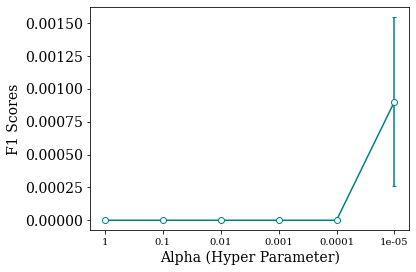

In [385]:
plt.errorbar(
    x=np.arange(len(alphas)),
    y=scores.mean(axis=0),
    yerr=scores.std(axis=0) / np.sqrt(repeat),
    marker='o', color='teal', mfc='w', capsize=2
)
plt.gca().set_xticks(np.arange(len(alphas)))
plt.gca().set_xticklabels(alphas, fontsize=10)
plt.xlabel('Alpha (Hyper Parameter)')
plt.ylabel('F1 Scores')
plt.savefig('SVD-Linear-Hyper.pdf')
plt.tight_layout()
plt.show()

In [392]:
repeat = 1
depths = np.arange(1, 51, 5)
scores = np.empty((repeat, len(depths)))

for r in range(repeat):
    for i, depth in enumerate(depths):
        clf = make_pipeline(
            StandardScaler(),
            DecisionTreeClassifier(criterion="entropy", max_depth=depth)
        )
        clf.fit(x_train, y_train.astype(int))
        y_valid_hat = clf.predict(x_valid)
        scores[r, i] = f1_score(y_valid, y_valid_hat, average='weighted')

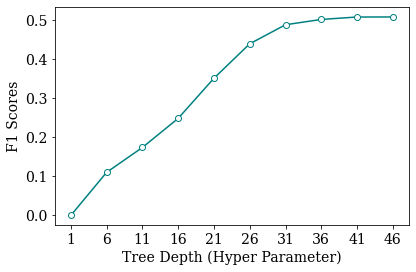

In [394]:
plt.plot(
    np.arange(len(depths)),
    scores.mean(axis=0),
    marker='o', color='teal', mfc='w',
)
plt.gca().set_xticks(np.arange(len(depths))[::1])
plt.gca().set_xticklabels(depths[::1])
plt.xlabel('Tree Depth (Hyper Parameter)')
plt.ylabel('F1 Scores')
plt.savefig('Decision-Tree-Hyper.pdf')
plt.tight_layout()
plt.show()

In [395]:
import tensorflow as tf

In [432]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(units=20, input_shape=[x_train.shape[1]], activation='relu'),
    #tf.keras.layers.Dropout(0.2),
    #tf.keras.layers.Dense(units=5, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
    )
model.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_58 (Dense)             (None, 20)                360       
_________________________________________________________________
dense_59 (Dense)             (None, 2)                 42        
Total params: 402
Trainable params: 402
Non-trainable params: 0
_________________________________________________________________


In [433]:
def norm(x): return (x - x_train.mean()) / x_train.std()

epoch_num = 10000
batch_size = 10000
want_validation = True

if want_validation:
    history = model.fit(
        norm(x_train), y_train,
        epochs=epoch_num, batch_size=batch_size,
        validation_data=(norm(x_valid), y_valid),
        verbose=0,
    )
else:
    history = model.fit(
        norm(x_train), y_train, 
        epochs=epoch_num, batch_size=batch_size,
        verbose=0,
    )

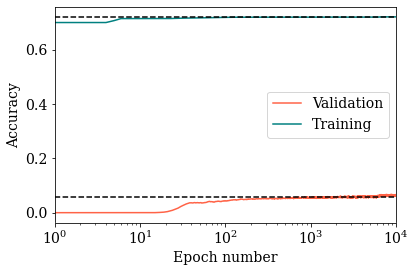

In [439]:
smooth = 10
if want_validation:
    plt.plot(
        ndimage.uniform_filter1d(
            history.history['val_accuracy'], smooth
            ), label='Validation', color='tomato'
    )
plt.plot(
    ndimage.uniform_filter1d(
    history.history['accuracy'], smooth
    ), label='Training', color='teal'
)
mean = np.mean(history.history['accuracy'])
plt.plot((0, len(history.history['accuracy'])), (mean, mean), color='k', ls='--')
mean = np.mean(history.history['val_accuracy'])
plt.plot((0, len(history.history['val_accuracy'])), (mean, mean), color='k', ls='--')
plt.xlabel("Epoch number")
plt.ylabel('Accuracy')
plt.xlim(1, 1e4)
plt.gca().set_xscale('log')
plt.legend()
plt.tight_layout()
plt.savefig('training_history.pdf')
plt.show()